In [1]:
from abc import ABC, abstractmethod

In [32]:
import yfinance as yf
import pandas as pd

In [243]:
tickers = ["AAPL", "MSFT", "GOOG"]
data= yf.download(tickers, start="2023-01-01", end="2024-01-01")['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [300]:
data.head()

Ticker,AAPL,GOOG,MSFT
Date,,,
2023-01-03,123.768448,89.480247,235.711731
2023-01-04,125.045036,88.492683,225.400925
2023-01-05,123.718987,86.557426,218.720551
2023-01-06,128.271103,87.944031,221.298233
2023-01-09,128.795578,88.582458,223.452896


In [55]:
class Asset(ABC):
    def __init__(self, name):
        self.name = name

    @abstractmethod
    def calculate_return(self):
        pass

In [57]:
class Stock(Asset):
    
    def __init__(self, name, prices):
        super().__init__(name)
        self.prices = prices
        
    def calculate_return(self):
        return self.prices.pct_change()
        

In [291]:
apple_stock_prices = data['AAPL']
microsoft_stock_prices=data['MSFT']
apple=Stock('apple',apple_stock_prices)
microsoft=Stock('microsoft',microsoft_stock_prices)

In [246]:
apple.calculate_return()

Date
2023-01-03         NaN
2023-01-04    0.010314
2023-01-05   -0.010605
2023-01-06    0.036794
2023-01-09    0.004089
                ...   
2023-12-22   -0.005547
2023-12-26   -0.002841
2023-12-27    0.000518
2023-12-28    0.002226
2023-12-29   -0.005424
Name: AAPL, Length: 250, dtype: float64

## Class Portfolio 

In [435]:
import numpy as np
from scipy.optimize import minimize


class Portfolio():
    def __init__(self):
        self._assets=[]
        self._weights=[]
        
    def get_assets(self):
        return self._assets
    
    
    def set_assets(self, assets):
        if not isinstance(assets, list):
            raise TypeError("Les actifs doivent être une liste.")
        self._assets = assets
        
        
        
    def get_weights(self):
        return self._weights
    

    def set_weights(self, weights):
        if not all(0 <= w <= 1 for w in weights):
            raise ValueError("Les poids doivent être entre 0 et 1.")
        if sum(weights) > 1:
            raise ValueError("La somme des poids ne peut pas dépasser 1.")
        self._weights = weights
        
    
    def add_asset(self,asset,weight):
        self._weights.append(weight)
        if not isinstance(asset, Asset):
            raise TypeError("L'objet ajouté doit être une instance de la classe Asset.")
        self._assets.append(asset)
       
        
        
    def portfolio_summary(self):
        details = "Détail du portefeuille :\n"
        for asset, weight in zip(self._assets, self._weights):
            details += f"- {asset.name}: {weight*100:.2f}%\n"
        return details
    
    
    def portfolio_return(self):
        # Calcul du rendement moyen pondéré
        returns = [asset.calculate_return() for asset in self._assets]
        portfolio_return = sum(weight * returns[i].mean() for i, weight in enumerate(self._weights))
        rendement = "Rendement du portefeuille :"
        rendement += f" {portfolio_return}"
        return rendement
    

    def portfolio_volatility(self):
        returns=np.array([asset.calculate_return().mean() for asset in self._assets])
        weights=np.array(self._weights)
        cov_mat=np.cov(returns)
        return "Volatilite du portfeuille " + f"{np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))}"
    
    
    ## Optimisation du portfeuille
    ## La méthode suivante optimise les pondérations des actifs pour minimiser le risque pour un rendement donné,
    ##   elle retourne les pondérations optimales pour atteindre le rendement cible
    
    
    def optimize_portfolio(self, target_return):
        ### target_return: Rendement cible du portefeuille
            
    
        # Fonction objectif pour minimiser la volatilité
        def objective(weights):
            returns = np.array([asset.calculate_return().mean() for asset in self._assets])
            cov_mat = np.cov(returns)
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
            return portfolio_volatility
    
    
        # Contrainte : le rendement du portefeuille doit être égal au rendement cible
        def return_constraint(weights):
            returns = np.array([asset.calculate_return().mean() for asset in self._assets])
            portfolio_return = np.dot(weights, returns)
            return portfolio_return - target_return
        
        # Contrainte : la somme des pondérations doit être égale à 1
        constraints = ({'type': 'eq', 'fun': return_constraint},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # Limites pour les pondérations (entre 0 et 1)
        bounds = [(0, 1) for _ in self._assets]

        # Initialisation des pondérations (également réparties)
        init_weights = np.array([1/len(self._assets) for _ in self._assets])

        # Optimisation des pondérations pour minimiser la volatilité
        result = minimize(objective, init_weights, method='SLSQP', bounds=bounds, constraints=constraints,options={'disp': True,'maxiter': 1000})

        # Enregistrer les pondérations optimales
        if result.success:
            self._weights = result.x
            print(f"Pondérations optimales : {self._weights}")
            return self._weights
        else:
            print("L'optimisation a échoué.")
            return result

  
        
        

In [430]:
##Rendment moyen journalier d'apple sur 2023
apple_return = apple.calculate_return().mean()
apple_return
microsoft_return=microsoft.calculate_return().mean()
microsoft_return

0.0019716604637613714

### Infos sur le portefeuille

In [437]:
portfolio = Portfolio()
portfolio.add_asset(apple,0.8)
portfolio.add_asset(microsoft,0.2)
## Détail du portfeuille
print(portfolio.portfolio_summary())
##Rendement du portfeuille
print(portfolio.portfolio_return())
## Volatilité du portfeuille
print(portfolio.portfolio_volatility())


Détail du portefeuille :
- apple: 80.00%
- microsoft: 20.00%

Rendement du portefeuille : 0.0018622744658995693
Volatilite du portfeuille 7.972806143772735e-05


### Optimisation pour un rendement cible de 0.02

In [438]:

target_return = 0.00186
optimal_weights = portfolio.optimize_portfolio(target_return)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.092177015650455e-05
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Pondérations optimales : [0.81663441 0.18336559]


### Avant de calculer la Var du portfeuille, analysons la distribution des rendments de chaque actifs

In [489]:
microsoft_returns=microsoft.calculate_return().dropna()

In [441]:
from scipy.stats import shapiro, normaltest

In [444]:
import matplotlib.pyplot as plt

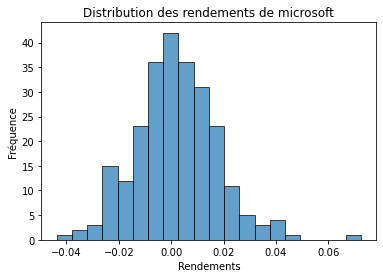

In [491]:
# Histogramme des rendements
plt.hist(microsoft_returns, bins=20, edgecolor='k', alpha=0.7)
plt.title("Distribution des rendements de microsoft")
plt.xlabel("Rendements")
plt.ylabel("Fréquence")
plt.show()

In [492]:
#  Test de Shapiro-Wilk pour tester la normalité des rendemets
shapiro_stat, shapiro_p = shapiro(microsoft_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9855, p-value=0.0124
Les rendements ne suivent pas une distribution normale (p <= 0.05).


In [471]:
apple_returns=apple.calculate_return().dropna()

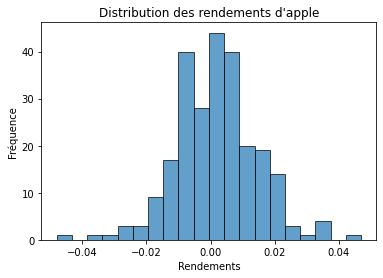

In [493]:
# Histogramme des rendements
plt.hist(apple_returns, bins=20, edgecolor='k', alpha=0.7)
plt.title("Distribution des rendements d'apple")
plt.xlabel("Rendements")
plt.ylabel("Fréquence")
plt.show()

In [494]:
# 1. Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(apple_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9857, p-value=0.0137
Les rendements ne suivent pas une distribution normale (p <= 0.05).


###  QQ-plot pour comparer la distribution empirique avec une distribution normale.

In [458]:
import statsmodels.api as sm

C:\Users\tarik\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


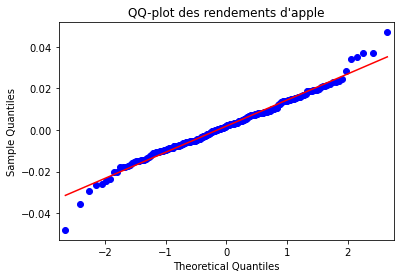

In [474]:

sm.qqplot(apple_returns, line='s')
plt.title("QQ-plot des rendements d'apple")
plt.show()

C:\Users\tarik\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


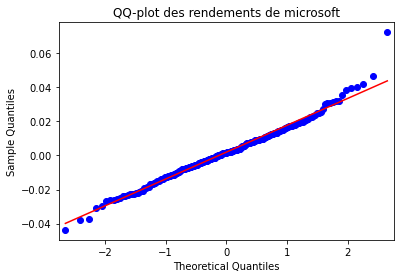

In [475]:
sm.qqplot(microsoft_returns, line='s')
plt.title("QQ-plot des rendements de microsoft")
plt.show()

### Calcul de la VaR et de la CVaR

In [520]:
### VAR HISTORIQUE

# Définir le niveau de confiance
confidence_level = 0.05  # Pour une VaR à 95 %, le seuil est 5 %
# Calcul de la VaR pour les actions d apple en 2023
VaR = np.percentile(apple_returns, confidence_level * 100)  ## ou 1-confidence level ?
print(f"VaR à {confidence_level * 100}% : {VaR:.4f}")


VaR à 5.0% : -0.0172


##### Calcul de la CVAR en se basant sur la Var historique

In [514]:
losses_beyond_var=apple_returns[apple_returns<VaR]

In [521]:
CVAR=losses_beyond_var.mean()
print(f"CVaR à {confidence_level * 100}% : {CVAR:.4f}")

CVaR à 5.0% : -0.0250


##### Skewness is the third moment of a distribution after mean and variance.

Negative skew: The mass of the distribution is concentrated on the right. Usually a right-leaning curve.

Positive skew: The mass of the distribution is concentrated on the left. Usually a left-leaning curve.

In finance, we would tend to want a positive skewness.

In [499]:
from scipy.stats import skew, kurtosis

print(f"Skewness : {skew(apple_returns.dropna())}")  

Skewness : 0.01168648674652285


In [500]:
print(f"Kurtosis : {kurtosis(apple_returns.dropna())}")  

Skewness : 1.3802895729982083


### Ajuster une loi de student sur les rendements d'apple

Le fait d'ajuster une loi (comme la loi t de Student) aux rendements signifie qu'on utilise cette loi pour modéliser les données. Cela se fait en estimant les paramètres de la loi (par exemple, degrés de liberté, moyenne, écart-type) pour qu'elle corresponde au mieux à la distribution observée des rendements (qui ne suivent pas une distribution normale).

L'objectif est de trouver les paramètres optimaux de la loi t de Student (ν,μ,σ) pour qu'elle représente les rendements réels.

La fonction t.fit estime les paramètres suivants :
ν (degrés de liberté) : contrôle l'épaisseur des queues.
μ (loc) : la moyenne des rendements ajustés.
σ (scale) : l'écart-type ajusté.

Degrés de liberté (df): 7.327092015229932, Location (loc): 0.0017600209120678223, Scale: 0.010701340312732276


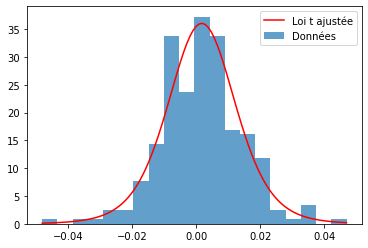

In [484]:
from scipy.stats import t

# Ajuster une loi t de Student sur les rendements d'apple
data = apple_returns 
df, loc, scale = t.fit(data)  # Paramètres de la loi t
print(f"Degrés de liberté (df): {df}, Location (loc): {loc}, Scale: {scale}")

# Comparer la densité des rendements avec la loi t ajustée

x = np.linspace(min(data), max(data), 100)
pdf = t.pdf(x, df, loc, scale)
plt.hist(data, bins=20, density=True, alpha=0.7, label="Données")
plt.plot(x, pdf, label="Loi t ajustée", color="red")
plt.legend()
plt.show()

### Ajustement de la VaR et de la CVaR

In [522]:
# Simuler des rendements non normaux (par exemple, loi t)
returns = apple_returns  # Rendements 

# Ajuster les paramètres de la loi t
df, loc, scale = t.fit(returns)

# Calcul de la VaR pour cette distribution
# La VaR à un niveau α est le quantile q=α d'une distribution de pertes
alpha=0.05
VaR_t = t.ppf(alpha, df, loc, scale)

# Calcul de la CVaR pour cette distribution
CVaR_t = t.expect(lambda x: x, args=(df,), lb=-np.inf, ub=VaR, loc=loc, scale=scale) / alpha

print(f"VaR (ajustée) : {VaR_t:.4f}")
print(f"CVaR (ajustée) : {CVaR_t:.4f}")

VaR (ajustée) : -0.0184
CVaR (ajustée) : -0.0289


### Visualiser les seuils de VaR et CVaR sur la distribution des rendements

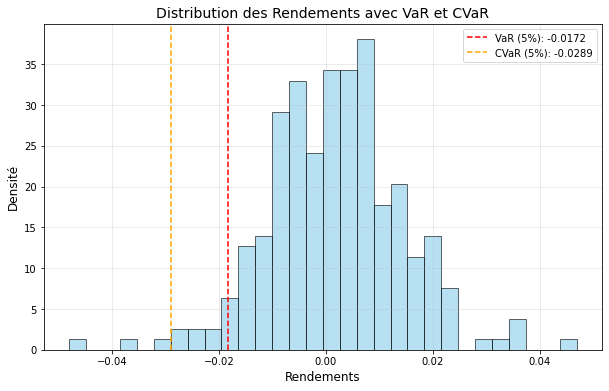

In [523]:
# Création de l'histogramme
alpha=0.05
plt.figure(figsize=(10, 6))
plt.hist(apple_returns, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Ajouter une ligne verticale pour la VaR
plt.axvline(VaR_t, color='red', linestyle='--', label=f"VaR ({alpha*100:.0f}%): {VaR:.4f}")

# Ajouter une ligne verticale pour la CVaR
plt.axvline(CVaR_t, color='orange', linestyle='--', label=f"CVaR ({alpha*100:.0f}%): {CVaR_t:.4f}")

# Ajouter des annotations
plt.title("Distribution des Rendements avec VaR et CVaR", fontsize=14)
plt.xlabel("Rendements", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.legend(fontsize=10)

# Afficher le graphique
plt.grid(alpha=0.3)
plt.show()

VaR (ligne rouge) :

Indique la perte maximale pour un niveau de confiance donné (α=5%).
Tout ce qui est à gauche de cette ligne représente des pertes extrêmes au-delà du seuil.
CVaR (ligne orange) :

Représente la perte moyenne conditionnelle au dépassement de la VaR.
Elle est plus négative que la VaR, car elle inclut toutes les pertes extrêmes.
